# Semi-supervised - pseudo labeling

In [89]:
%load_ext autoreload
%autoreload 2

import pickle
from pathlib import Path

import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning import Trainer, seed_everything
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

from util.plot import Plot
plot = Plot()

SUP_TRAIN_PATH = Path('../data/wust-train-sentence-embeddigs.pickle')
SUP_TEST_PATH = Path('../data/wust-test-sentence-embeddigs.pickle')
UNSUP_PATH = Path('../data/unsup_small_embeddings.pickle')

device = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)

seed_everything(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


42

## Model

In [90]:
class HerbertEmotionClassifier(pl.LightningModule):
    lr = 1e-3

    def __init__(self):
        super().__init__()

        num_classes = 9

        weight = torch.tensor(
            [
                0.01030928,
                0.00552486,
                0.00344828,
                0.01388889,
                0.02222222,
                0.01204819,
                0.02272727,
                0.00307692,
                0.00055249,
            ]
        )

        self.criterion = nn.CrossEntropyLoss(weight=weight)
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(128, num_classes),
        )

    def forward(self, embedded_inputs):
        return self.classifier(embedded_inputs)

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), self.lr)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch

        logits = self.forward(x)
        loss = self.criterion(logits, y)
        self.log("train/loss", loss)

        return loss


## Data

In [91]:
with SUP_TRAIN_PATH.open('rb') as file:
    sup_train = pickle.load(file)

with SUP_TEST_PATH.open('rb') as file:
    sup_test = pickle.load(file)

with UNSUP_PATH.open('rb') as file:
    unsup = pickle.load(file)
    unsup_x = unsup['sentence_embeddings']
    unsup_x = torch.FloatTensor(unsup_x).to(device)

sup_train_labels = np.array(sup_train['labels']).reshape(-1, 1)
sup_test_labels = np.array(sup_test['labels']).reshape(-1, 1)


sup_train_x = torch.FloatTensor(sup_train['sentence_embeddings']).to(device)
sup_test_x = torch.FloatTensor(sup_test['sentence_embeddings']).to(device)

encoder = LabelEncoder()
encoder.fit(sup_train_labels)

sup_train_y = encoder.transform(sup_train_labels)
sup_test_y = encoder.transform(sup_test_labels)
sup_train_y = torch.LongTensor(sup_train_y).to(device)
sup_test_y = torch.LongTensor(sup_test_y).to(device)

sup_train_ds = TensorDataset(sup_train_x, sup_train_y)
sup_train_dl = DataLoader(
    sup_train_ds,
    batch_size=100,
    shuffle=True
)

## Teacher

In [92]:
teacher = HerbertEmotionClassifier()
teacher_trainer = Trainer(
    max_epochs=50,
    gpus=1,
    deterministic=True,
    accumulate_grad_batches=4,
    checkpoint_callback=False,
    logger=False
)

teacher_trainer.fit(teacher, sup_train_dl)
teacher.eval()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | classifier | Sequential       | 230 K 
------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
Epoch 49: 100%|██████████| 30/30 [00:00<00:00, 265.48it/s, loss=0.919]


HerbertEmotionClassifier(
  (criterion): CrossEntropyLoss()
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [93]:
y_pred = teacher(sup_test_x.cpu())
y_pred = torch.argmax(y_pred, dim=1).numpy()
y_pred = encoder.inverse_transform(y_pred)
y_test = encoder.inverse_transform(sup_test_y.cpu())

In [94]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   neutralne       0.71      0.96      0.82       777
 oczekiwanie       0.00      0.00      0.00        42
      podziw       0.00      0.00      0.00        77
      radosc       0.38      0.56      0.45       124
      smutek       0.00      0.00      0.00        31
      strach       0.00      0.00      0.00        20
      wstret       0.09      0.06      0.07        35
 zaskoczenie       0.00      0.00      0.00        19
       zlosc       0.00      0.00      0.00       139

    accuracy                           0.65      1264
   macro avg       0.13      0.18      0.15      1264
weighted avg       0.48      0.65      0.55      1264



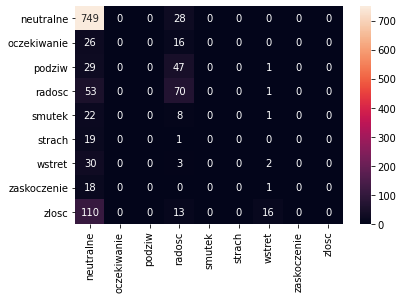

In [95]:
plot.confusion_matrix(y_test, y_pred)

In [96]:
predictions = student(sup_test_x.cpu())
y_test = sup_test_y.cpu().numpy()
top2 = torch.argsort(predictions, axis=1)[:, -2:].cpu().numpy()
in_top_k = [1 if y_test[k] in top2[k] else 0 for k in range(len(y_test))]
np.mean(in_top_k)

0.6479430379746836

## Student

In [97]:
unsup_y = teacher(unsup_x.cpu())
unsup_y = torch.argmax(unsup_y, dim=1).to(device)

unsup_ds = TensorDataset(unsup_x, unsup_y)
unsup_ds_dl = DataLoader(
    unsup_ds,
    batch_size=1000,
    shuffle=True
)

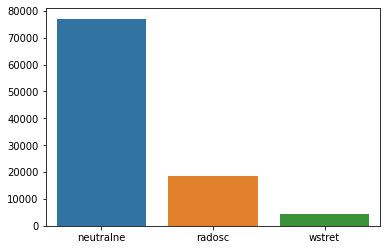

In [98]:
unsup_y_labels = unsup_y.cpu().numpy()
unsup_y_labels = encoder.inverse_transform(unsup_y_labels)
plot.class_balance(unsup_y_labels)

In [99]:
student = HerbertEmotionClassifier()
student_trainer = Trainer(
    max_epochs=50,
    gpus=1,
    deterministic=True,
    accumulate_grad_batches=4,
    checkpoint_callback=False,
    logger=False
)

student_trainer.fit(student, unsup_ds_dl)
student.eval()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | classifier | Sequential       | 230 K 
------------------------------------------------
230 K     Trainable params
0         Non-trainable params
230 K     Total params
Epoch 49: 100%|██████████| 100/100 [00:01<00:00, 89.29it/s, loss=0.0811]


HerbertEmotionClassifier(
  (criterion): CrossEntropyLoss()
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=9, bias=True)
  )
)

In [100]:
y_pred = student(sup_test_x.cpu())
y_pred = torch.argmax(y_pred, dim=1).numpy()
y_pred = encoder.inverse_transform(y_pred)
y_test = encoder.inverse_transform(sup_test_y.cpu())

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

   neutralne       0.71      0.95      0.81       777
 oczekiwanie       0.00      0.00      0.00        42
      podziw       0.00      0.00      0.00        77
      radosc       0.38      0.59      0.46       124
      smutek       0.00      0.00      0.00        31
      strach       0.00      0.00      0.00        20
      wstret       0.08      0.06      0.07        35
 zaskoczenie       0.00      0.00      0.00        19
       zlosc       0.00      0.00      0.00       139

    accuracy                           0.65      1264
   macro avg       0.13      0.18      0.15      1264
weighted avg       0.48      0.65      0.55      1264



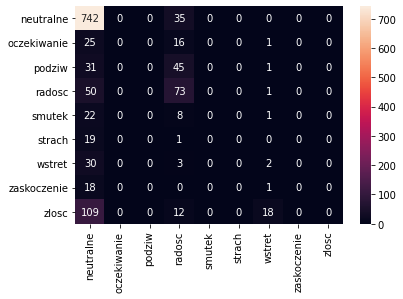

In [102]:
plot.confusion_matrix(y_test, y_pred)

In [103]:
predictions = student(sup_test_x.cpu())
y_test = sup_test_y.cpu().numpy()
top2 = torch.argsort(predictions, axis=1)[:, -2:].cpu().numpy()
in_top_k = [1 if y_test[k] in top2[k] else 0 for k in range(len(y_test))]
np.mean(in_top_k)

0.7215189873417721